# Merging Localizations in Time

A very common processing routine in SMLM is to merge localizations that appear in successive (and sometimes non-successive) frames. The idea is that molecules that emit for more than one camera frame may be mistakenly attributed to separate molecules, a problem that is especially prevalent in counting applications.

All of the credit for providing merging functionality in B-Store goes to the [Trackpy](http://soft-matter.github.io/trackpy/) library for Python. Trackpy, which is not associated with B-Store, is a general purpose Python implementation of the Crocker-Grier tracking algorithm. It is fast, well-documented, and well-maintained. B-Store provides a wrapper around Trackpy's primary function, `link_df()`, to make the library's functionality a little more focused on SMLM.

In [1]:
# Import the essential bstore libraries
%pylab inline
from bstore import processors as proc
import pandas as pd

# This is part of Python 3.4 and greater and not part of B-Store
from pathlib import Path

Populating the interactive namespace from numpy and matplotlib


## Get the test data
You can get the test data for this tutorial from the B-Store test repository at https://github.com/kmdouglass/bstore_test_files. Clone or download the files and change the filename below to point to the folder *bstore_test_files/processor_test_files/* within this repository.

In [2]:
dataDirectory = Path('../../bstore_test_files/processor_test_files/') # ../ means go up one directory level

## Brief overview of the Merge processor

This example demonstrates how to use the [Merge](http://b-store.readthedocs.io/en/latest/bstore.html#bstore.processors.Merge) processor in B-Store's analysis tools. This processor takes as input a Pandas DataFrame containing localization data.

As an output, the processor produces a DataFrame, but its contents can actually differ substantially depending on whether a `statsComputer` is specified. If a `statsComputer` is specified, the columns are aggregated depending on the meaning of each column. For example, the number of photons from each localization is summed when localizations are merged, whereas the x- and y-positions are reduced to one number by a photon-weighted mean operation.

If no `statsComputer` is specified, the original DataFrame returned with one additonional column labeled `particle`. The number in this column is a unique ID assigned to track of localizations.

# Step one: load the data

In [3]:
locsFile = dataDirectory / Path('merge.csv')

with open(str(locsFile), 'r') as f:
    locs = pd.read_csv(f, skiprows = 2)

In [4]:
locs

,x,y,z,frame,precision,photons,background,loglikelihood,sigma
0,10,10,0,0,10.0,1000,100,100,150
1,20,20,0,1,5.0,500,100,150,145
2,0,20,0,2,10.0,2000,200,100,155
3,100,100,0,2,10.0,1000,100,100,150
4,0,0,0,3,5.0,1000,100,50,150
5,110,110,0,3,5.0,500,100,150,145
6,90,110,0,4,10.0,2000,200,100,155
7,90,90,0,5,5.0,1000,100,50,150
8,20,0,0,6,7.5,1000,100,100,150
9,110,90,0,6,7.5,1000,100,100,150


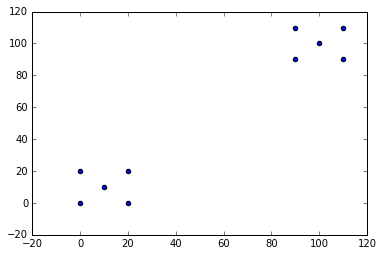

In [5]:
plt.scatter(locs['x'], locs['y'])
plt.show()

The plot above shows that there are two clusters of five localizations. In reality, each localization originates from a different frame; we would like to extract the trajectory of each localization.

# Step two: set up the Merge processor

Like all processors, we first create an instance of the `Merge` processor by assigning different parameters to it. `Merge` takes up to 6 parameters:

1. mergeRadius - the radius of a circle centered on a localization in which the next localization may appear and be counted as part of the same trajectory
2. tOff - the memory time; if a localization does not appear within the circle defined by mergeRadius after tOff frames have elapsed, the trajectory is terminated and only new trajectories can appear in this region
3. autoFindMergeRadius - a boolean (True or False); if true, the mergeRadius is set to three times the mean localization precision of the DataFrame
4. statsComputer - the object that computes trajectory statistics
5. coordCols - the column names of the localizations' coordinates
6. precisionColumn - the name of the column containing the localization precision, if present

# Step three: merge the localizations

Let's do a simple merge operation. We'll first create a `Merge` processor named `merger`, set the mergeRadius to 25 and the off time to 2. Then we merge the localization DataFrame by calling `merger` with `locs` as an argument.

In [6]:
# Accept the defaults for all but mergeRadius and tOff
merger = proc.Merge(mergeRadius = 25, tOff = 2)
output = merger(locs)

Frame 6: 2 trajectories present


In [7]:
output

,x,y,z,frame,precision,photons,background,loglikelihood,sigma,particle
0,10,10,0,0,10.0,1000,100,100,150,0.0
1,20,20,0,1,5.0,500,100,150,145,0.0
2,0,20,0,2,10.0,2000,200,100,155,0.0
3,0,0,0,3,5.0,1000,100,50,150,0.0
4,20,0,0,6,7.5,1000,100,100,150,0.0
5,100,100,0,2,10.0,1000,100,100,150,1.0
6,110,110,0,3,5.0,500,100,150,145,1.0
7,90,110,0,4,10.0,2000,200,100,155,1.0
8,90,90,0,5,5.0,1000,100,50,150,1.0
9,110,90,0,6,7.5,1000,100,100,150,1.0


From the above output you can see that an additonal column named `particle` was added to the DataFrame and that each row contains one of two numbers: 0 and 1. These integers identify the unique trajectories of localizations that were identified during the tracking.

Notice that the particle id 0 consists of localizations in frames 0, 1, 2, 3, and 6. What would happen if the memory time, `tOff` had been shorter?

In [8]:
merger = proc.Merge(mergeRadius = 25, tOff = 1)
merger(locs)

Frame 6: 2 trajectories present


,x,y,z,frame,precision,photons,background,loglikelihood,sigma,particle
0,10,10,0,0,10.0,1000,100,100,150,0.0
1,20,20,0,1,5.0,500,100,150,145,0.0
2,0,20,0,2,10.0,2000,200,100,155,0.0
3,0,0,0,3,5.0,1000,100,50,150,0.0
4,100,100,0,2,10.0,1000,100,100,150,1.0
5,110,110,0,3,5.0,500,100,150,145,1.0
6,90,110,0,4,10.0,2000,200,100,155,1.0
7,90,90,0,5,5.0,1000,100,50,150,1.0
8,110,90,0,6,7.5,1000,100,100,150,1.0
9,20,0,0,6,7.5,1000,100,100,150,2.0


Now you can see that the localization in frame 6 was not merged into the same trajectory because it appeared too late in time. It now has a separate ID of 2.

# Computing merged stats

B-Store comes with a basic stats computer called `MergeFang` and `MergeFangTS`. (The latter works with datasets whose column names match ThunderSTORM output.)

In [9]:
computer = proc.MergeFang()

# Assign the new computer to merger's statsComputer attribute,
# rather than make a new merger
merger.statsComputer = computer

# Reset tOff
merger.tOff = 2

# Perform the merging again
merger(locs)

Frame 6: 2 trajectories present


,particle,x,y,z,sigma,frame,photons,background,loglikelihood,length
0,0.0,8.619288,10.236893,0.0,150,0,5500,600,100,5
1,1.0,98.619288,100.236893,0.0,150,2,5500,600,100,5


The output of merger when the `MergeFang` stats computer is set is now different. Each row now corresponds to just one trajectory ID and each column has been aggregated. `x` and `y` were combined using a photon weighted-average. `photons` and `background` were summed, the minimum `frame` was taken, and `sigma` and `loglikelihood` were averaged.

## Write your own statsComputer

It's difficult to write a generic stats computer for B-Store because B-Store does not enforce a column naming standard. Therefore, a different statsComputer is required to know how to reduce each column.

To provide help in writing your own, here is what MergeFang's code looks like.

In [10]:
import inspect

In [11]:
code = inspect.getsource(proc.MergeFang)
print(code)

class MergeFang(MergeStats):
    """Merger for localizations computed from Fang's sCMOS MLE software.
    
    """
    def computeStatistics(self, df, particleCol = 'particle'):
        """Calculates the statistics of the linked trajectories.
        
        Parameters
        ----------
        df          : Pandas DataFrame
            DataFrame containing linked localizations.
        particleCol : str
            The name of column containing the merged partice ID's.
            
        Returns
        -------
        procdf : Pandas DataFrame
            DataFrame containing the fully merged localizations.
            
        """
        particleGroups         = df.groupby(particleCol)        
        
        tempResultsX           = particleGroups.apply(self._wAvg, 'x')
        tempResultsY           = particleGroups.apply(self._wAvg, 'y')
        tempResultsZ           = particleGroups.apply(self._wAvg, 'z')
        tempResultsMisc        = particleGroups.agg({'loglikelihood

### Walkthrough of the code

First, MergeFang inherits from a parent class called `MergeStats`. Only one function is defined for this class, and its named `computeStatistics`. As inputs, the function takes a DataFrame that has already been merged, i.e. has a `particle` column, and the name of the particle column.

```python
class MergeFang(MergeStats):
    def computeStatistics(self, df, particleCol = 'particle'):
```

The function uses Python [Pandas](http://pandas.pydata.org/) routines to form groups of rows from the DataFrame grouped by particle ID with this line:

```python
particleGroups         = df.groupby(particleCol)
```

Then, each column in the groups is aggregated and stored in a temporary Series or DataFrame object. The x-, y- and z- columns are combined using a photon-weighted average that is defined in the `MergeStats` parent class as a convenience.

```python
tempResultsX           = particleGroups.apply(self._wAvg, 'x')
tempResultsY           = particleGroups.apply(self._wAvg, 'y')
tempResultsZ           = particleGroups.apply(self._wAvg, 'z')
```

For the rest, we specify what to do with each individual column like so:

```python
 tempResultsMisc        = particleGroups.agg({'loglikelihood' : 'mean',
                                              'frame'         : 'min',
                                              'photons'       : 'sum',
                                              'background'    : 'sum',
                                              'sigma'         : 'mean'})
tempResultsLength      = pd.Series(particleGroups.size())
```

Next, the temporary Series and DataFrames are renamed and recombined into one DataFrame:

```python
# Rename the series
tempResultsX.name      = 'x'
tempResultsY.name      = 'y'
tempResultsZ.name      = 'z'
tempResultsLength.name = 'length'

# Create the merged DataFrame
dataToJoin = (tempResultsX,
              tempResultsY,
              tempResultsZ,
              tempResultsMisc,
              tempResultsLength)
procdf = pd.concat(dataToJoin, axis = 1)
```

Finally, we do some bookkeeping to move the `particle` index to a regular column so it is saved during batch processing (batch processors in B-Store don't save information in index columns) and return the new DataFrame.

```python
# Move the particle ID to a regular column        
procdf.reset_index(particleCol, inplace = True)

return procdf
```

If you have different column names, you can simply modify the above code and create a new `statsComputer`. For example, if your column name for the background is `bg`, you could change `background` in the above code to `bg`:

```python
 tempResultsMisc        = particleGroups.agg({'loglikelihood' : 'mean',
                                              'frame'         : 'min',
                                              'photons'       : 'sum',
                                              'bg'            : 'sum',
                                              'sigma'         : 'mean'})
```

# Summary

1. The **Merge** processor relies on the [Trackpy](http://soft-matter.github.io/trackpy/) package for its functionality.
2. Merging combines localizations that are close together in both space **and** time.
3. If localizations are spaced farther apart than `mergeRadius` and `tOff` in space and time, they will not be merged into one trajectory.
4. A `statsComputer`, like the builtin `MergeFang` condenses the columns using different statistics based on the meaning of the column.
5. You can write your own custom `statsComputer` by extending the `MergeStats` abstract base class.